# Topic Modelling on Wiki & Metaphor Corpus
*Anastasia Nikiforova. HSE, Computational Linguistics*

*Thesis: Metaphor Identification using Topic Modeling*

## Contents

1. Downloading, parsing and preprocessing Wikipedia with Corpuscula and Pymorphy2.
2. Saving wiki articles in Vowpal Wabbit format.
3. Loading & Preprocessing Metaphor Corpus.
4. Running BigARTM on Wikipedia.
5. Bulk training & scoring several topic models.
7. Fitting best topic models on the Metaphor Corpus.

Further notebooks:

8. Running Classification on Metaphor Corpus.
9. Model Scoring.
10. Theta matrix analysis

All Necessary Imports:

In [ ]:
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from string import punctuation
from itertools import chain
from collections import Counter

import nltk
nltk.download("stopwords")

#Create lemmatizer and stopwords list 
russian_stopwords = stopwords.words("russian")
russian_stopwords += ['ваш', 'наш', 'твой', 'который', 'это', 'то', 'что', 'кто', 'какой']

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import artm

___________________

## Wikipedia Parsing and Preprocessing

In [39]:
#!wget https://dumps.wikimedia.org/ruwiki/20200501/ruwiki-20200501-pages-meta-current4.xml-p1938396p3398621.bz2

--2020-05-20 11:23:58--  https://dumps.wikimedia.org/ruwiki/20200501/ruwiki-20200501-pages-meta-current4.xml-p1938396p3398621.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 835477628 (797M) [application/octet-stream]
Saving to: ‘ruwiki-20200501-pages-meta-current4.xml-p1938396p3398621.bz2’

ruwiki-20200501-pag 100%[===================>] 796.77M  1.51MB/s    in 4m 32s  

2020-05-20 11:28:31 (2.93 MB/s) - ‘ruwiki-20200501-pages-meta-current4.xml-p1938396p3398621.bz2’ saved [835477628/835477628]



In [331]:
!wget https://dumps.wikimedia.org/ruwiki/20200501/ruwiki-20200501-pages-articles5.xml-p3398622p4898621.bz2

--2020-05-23 19:24:28--  https://dumps.wikimedia.org/ruwiki/20200501/ruwiki-20200501-pages-articles5.xml-p3398622p4898621.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.7, 2620:0:861:1:208:80:154:7
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 721724963 (688M) [application/octet-stream]
Saving to: ‘ruwiki-20200501-pages-articles5.xml-p3398622p4898621.bz2’

ruwiki-20200501-pag 100%[===================>] 688.29M  3.72MB/s    in 2m 24s  

2020-05-23 19:26:53 (4.79 MB/s) - ‘ruwiki-20200501-pages-articles5.xml-p3398622p4898621.bz2’ saved [721724963/721724963]



In [332]:
from corpuscula.conllu import Conllu
from corpuscula import corpus_utils
from corpuscula.wikipedia_utils import Wikipedia
from toxine.wikipedia_utils import TokenizedWikipedia
import re

In [333]:
from nltk.tokenize import word_tokenize
from string import punctuation
from itertools import chain

In [12]:
def replace_tokens(seq):
    '''A function to replace or remove certain tokens from the corpus.
    
    <NUM_UINT>          Integers greater than 3001 (so that all year references are left as is).
    <NUM_SINT>          Numbers with `+` or `-` in front of them, e.g. negative numbers, temperature etc.
    <NUM_FLOAT>         Decimals with floating comma/dot
    <NUM_UINT>-{token}  Tokens with numbers like "20-летний".
    
    All the garbage strings like "yhfvkлнмилрои6237" that have both Cyrillic and Latin alphabet 
    and/or numbers, symbols are removed.
    
    Exception: strings like "HTML-страница", where first part of the token is Latin letters, 
    then dash, and the second part is Cyrillic letters.
    '''
    
    tokens = word_tokenize(seq.lower().replace('\xa0', ' ').replace('\n', ' '))
    
    processed_seq = []
    for token in tokens:
        if token in punctuation+'«»':
            continue
        elif token.isdecimal():
            # replace all numbers longer than 3001 with <NUM>
            if int(token) > 3001:
                token = '<NUM_UINT>'

        elif re.match(r'[+-]\d+', token):
            # if the number has a decimal part or (+-) in front, leave as-is (+36,6)
            token = '<NUM_SINT>'

        elif re.match(r'[+-]?\d+[.,]\d*$', token):
            # Decimals with floating comma/dot
            token = '<NUM_FLOAT>'

        elif re.match(r'[`’\'²³°$€%&~№()/"\«»„“+.,:;!?-]+$', token) \
          or re.match(r'[a-zA-Z]+-[а-яА-ЯёЁ]+$', token):
            # special symbols is left as-is
            # cases like 'HTLV-вирус', 'HTML-страница', 'ascii-код',
            #     'ftp-аутентификация' etc.
            pass

        elif re.match(r'\d+-[а-яА-ЯёЁ]+$', token):
            # 20-градусный
            token = re.sub(r'\d+', '<NUM_UINT>', token)
            
        # garbage tokens are removed
        elif re.search(r'[^a-zA-Zа-яА-ЯёЁ°²³.-]', token) \
               or (re.match(r'[a-zA-Z]', token)
               and re.match(r'[а-яА-ЯёЁ]', token)) \
               or (token in punctuation):
            
            continue
            
        processed_seq.append(token)
    
    return processed_seq

In [13]:
def clear_stdin():
    '''Helper function for tqdm library glitches (newlines).
    '''
    if hasattr(tqdm, '_instances'):
        for instance in list(tqdm._instances):
            tqdm._decr_instances(instance)

def pos_lemma_word(word):
    '''POS-tag and lemmatize one word,
    can be used separately from the main preprocess_pymorphy function.
    '''
    if '<num' in word.lower() or word.isdecimal():
        word_lemma = word
        word_pos = 'NUMR'
        word_lemma_pos = word+'_NUMR'
    else:
        res = morph.parse(word)[0]
        if res.tag.POS and res.normal_form and len(res.tag.POS)>1 \
            and res.normal_form not in russian_stopwords:
            word_lemma = res.normal_form
            word_pos = res.tag.POS
            word_lemma_pos = str(res.normal_form) + '_' + str(res.tag.POS)
            
        else:
            word_lemma = None
            word_pos = None
            word_lemma_pos = None
            
    return word_lemma, word_pos, word_lemma_pos
            
def preprocess_pymorphy(article):
    '''
    POS-tag and lemmatize a text.
    
    Args:
        article:      list of strings - tokenized text; here, a wiki article.
    '''
    
    clear_stdin()

    lemmas = []
    pos = []
    lemma_pos = []    

    for word in article:

        word_lemma, word_pos, word_lemma_pos = pos_lemma_word(word)

        if word_lemma is not None:
            lemmas.append(word_lemma)
            pos.append(word_pos)
            lemma_pos.append(word_lemma_pos)

        else:
            continue

    return lemmas, pos, lemma_pos

In [ ]:
#preprocess_pymorphy(replace_tokens('Как твои крепости +4 -32.4 jhasdb3u4 красиво-нет из-за 100000'))

In [145]:
#replace_tokens("Рыбаков.\n\nФакультет ВШОПФ им. Н.\xa0И.\xa0Лобачевского\xa0— базовый Э,Ж ; 35.3 -1 1984 1002084 nlp-коммьюнити text.com")

### Saving Preprocessed Corpus

In [337]:
parsed_corpus = 'wiki_articles_parsed_part2.txt'
with open(parsed_corpus, 'wt', encoding='utf-8') as f:
    # to export lemmas, pos and lemma_pos:
    #[print(preprocess_pymorphy(replace_tokens(art[2])), file=f) for art in Wikipedia().articles()]
    
    # to export only lemma_pos:
    [print(preprocess_pymorphy(replace_tokens(art[2]))[2], file=f) for art in Wikipedia().articles()]

Process Wikipedia
[=======] 628950                                                     
Wikipedia has been processed: 50651403 lines, 628950 articles


In [338]:
wiki_vw = open('wiki_articles_parsed_part2.txt', encoding='utf-8').readlines()

In [339]:
import ast

In [340]:
wiki_lp = []
# wiki_l = []
# wiki_p = []

clear_stdin()

for i in tqdm(wiki_vw):
    output = ast.literal_eval(i)
    # if lemmas, pos and lemma_pos were exported earlier:
#     wiki_l.append(output[0])
#     wiki_p.append(output[1])
#     wiki_lp.append(output[2])

    # if only lemma_pos was exported
    wiki_lp.append(output)

100%|██████████| 628950/628950 [01:40<00:00, 6253.27it/s] 


### Filtering Wiki Corpus and Saving it in CSV.

In [341]:
wiki_lp = [i for i in wiki_lp if len(i)>15]

# if lemma and pos were also exported:
# wiki_l = [i for i in wiki_l if len(i)>15]
# wiki_p = [i for i in wiki_p if len(i)>15]

In [ ]:
# print("Unique POS-tags in the corpus:", len(dict(Counter(list(chain.from_iterable(wiki_p))))))

In [343]:
print("Unique tokens in the corpus:", len(dict(Counter(list(chain.from_iterable(wiki_lp))))))

Unique tokens in the corpus: 1101039


In [344]:
wiki_df = pd.DataFrame()

wiki_df['lemma_pos'] = wiki_lp

# if lemma and pos were also exported:
# wiki_df['lemmas'] = wiki_l
# wiki_df['pos'] = wiki_p

wiki_df.to_csv('wikipedia_processed_lemma-pos_part2.csv', index=False) 

In [345]:
wiki_df.head()

,lemma_pos
0,"[верхний_ADJF, далъёль_NOUN, устарый_ADJS, вер..."
1,"[верхний_ADJF, коммуна_NOUN, река_NOUN, россия..."
2,"[верхний_ADJF, налдэг_NOUN, река_NOUN, россия_..."
3,"[верхний_ADJF, омр_NOUN, река_NOUN, россия_NOU..."
4,"[верхний_ADJF, пидж_NOUN, река_NOUN, россия_NO..."


### Saving Processed Articles in Vowpal Wabbit Format

In [346]:
def save_wiki_txt(filename, savelist):
    with open(filename, 'wt') as f:
        for i in savelist:
            print(' '.join(i), file=f)

In [204]:
save_wiki_txt(filename='wiki_lemma_pos_part2.txt', savelist=wiki_lp)

# if lemma and pos were also exported:
#save_wiki_txt(filename='wiki_lemmas.txt', savelist=wiki_l)
#save_wiki_txt(filename='wiki_pos.txt', savelist=wiki_p)

### Optional: Shorter random subcorpus of wiki for faster topic modelling
If you want to experiment with smaller corpus to speed up, create a tandom subcorpus of desired maxlen

In [348]:
wiki_full = open('wiki_lemma_pos.txt').readlines()

In [128]:
wiki_full[0][:50]

'высокий_ADJF школа_NOUN общий_ADJF прикладной_ADJF'

In [129]:
from random import shuffle
shuffle(wiki_full)     # shuffle full corpus

In [130]:
wiki_full[0][:50]

'кришул-негр_NOUN фекете-кёрёша_NOUN река_NOUN запа'

In [131]:
maxlen = 1000000
wiki_short = wiki_full[:maxlen]
len(wiki_short)

303469

In [57]:
#wiki_short[1001]

'бомбомёт_NOUN устройство_NOUN судно_NOUN сбрасывание_NOUN глубинный_ADJF бомба_NOUN морской_ADJF бомбомёт_NOUN огневой_ADJF средство_NOUN надводный_ADJF судно_NOUN стрельба_NOUN глубинный_ADJF бомба_NOUN цель_NOUN борьба_NOUN подводный_ADJF лодка_NOUN противоторпедный_ADJF оборона_NOUN бомбомёт_NOUN бывать_VERB механический_ADJF штоковый_ADJF шточный_ADJF часто_ADVB неправильно_ADVB отождествлять_VERB бомбосбрасыватель_NOUN газодинамический_ADJF реактивный_ADJF сантиметр_NOUN также_CONJ морской_ADJF миномёт_NOUN хеджхог_NOUN ссылка_NOUN\n'

In [318]:
def save_wiki(filename, savelist):
    with open(filename, 'wt') as f:
        for i in savelist:
            print(i.rstrip('\n'), file=f)

In [59]:
save_wiki('wiki_subcorp.txt', wiki_short)

In [60]:
wiki_short = open('wiki_subcorp.txt').readlines()
len(wiki_short)

100000

### Minor Additional Filtering, Creating Bigrams & Converting Data to word:count format for BigARTM

When building topic models, additional stop words were discovered that should be also removed from the corpus.

In [391]:
from gensim.models import Phrases

In [385]:
wiki_full = open('wiki_lemma_pos.txt', encoding='utf-8').readlines() + \
            open('wiki_lemma_pos_part2.txt', encoding='utf-8').readlines()

In [421]:
def add_bigrams(docs):
    '''Add bigrams to the corpus using `gensim.models.Phrases`
    '''
    clear_stdin()
    docs = [a.split() for a in docs]
    bigram = Phrases(docs, min_count=3, delimiter=b'+')
    for idx in tqdm(range(len(docs))):
        for token in bigram[docs[idx]]:
            if '+' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    docs = [' '.join(a) for a in docs]    
    return docs

In [422]:
wiki_full = add_bigrams(wiki_full)

100%|██████████| 637568/637568 [05:49<00:00, 1826.48it/s]


In [423]:
len(wiki_full)   # number of articles in preprocessed wiki dataset

637568

In [425]:
#wiki_full[0]

In [359]:
len(set(chain.from_iterable([i.split() for i in wiki_full])))  # unique tokens in preprocessed wiki dataset

1684495

In [426]:
def corpus_to_vw(corpus, filename='output.txt'):
    ''' Convert text to Vowpal Wabbit format.
    Each text will be presented as a bag of words, e.g. "doc1 cat:3 sat:5 mat:1",
    where the number represents how many times a word appears in current document.
    
    Args:
        corpus:     a list of strings with preprocessed documents.
    '''
    corpus_counter = [dict(Counter(i.strip('\n').split())) for i in corpus]
    exclusions = ['также_CONJ', 'б_PRCL', 'около_PREP', 'ещё_ADVB', 'э_INTJ', 'её_ADJF', 'весь_ADJF',
                  'однако_CONJ', 'например_CONJ', 'из-за_PREP', 'среди_PREP', 'свой_ADJF']
    
    with open(filename, 'wt', encoding='utf-8') as f:
        doc_n = 1
        for article in corpus_counter:
            text = "doc{} ".format(doc_n)
            for k, v in article.items():
                if k not in exclusions:
                    text += str(k) + ':' + str(v) + ' '
            print(text, file=f)
            doc_n+=1
corpus_to_vw(wiki_full, 'wiki_full_vw.txt')

In [14]:
# testing = open('wiki_full_vw.txt').readlines()
# testing[-1]

## Loading & Preprocessing Metaphor corpus

In [7]:
import pandas as pd
from tqdm import tqdm

In [8]:
metcorp = pd.read_csv('metaphor_dataset.csv', index_col=False)

In [9]:
metcorp.head(3)

,sent,verb,Class,sent_with_target
0,"Конечно же , Вам не нужно все время ребенка му...",бомбардировать,1,"Конечно же , Вам не нужно все время TARGET реб..."
1,"Добрынин тогда говорил Шевченко , "" что Центр ...",бомбардировать,1,"Добрынин тогда говорил Шевченко , "" что Центр ..."
2,"Если принять во внимание , как настойчиво « гр...",бомбардировать,1,"Если принять во внимание , как настойчиво « гр..."


### Preprocessing target sentences: lemmatization, pos-tagging, removing stop words

Applying the same preprocessing as to Wikipedia corpus and saving in vowpal wabbit format.

Experimenting part, skip to uncommented lines of code to proceed with the pipeline

In [81]:
# processed_sents = [' '.join(preprocess_pymorphy(replace_tokens(i))[2]) for i in list(metcorp['sent'])]

In [85]:
# processed_sents[1392]

'воидти_GRND долго_ADVB стоялый_ADJS воздеть_PRTF небо_NOUN рука_NOUN стоялый_ADJS сзади_ADVB молиться_GRND страх_NOUN ибо_CONJ видение_NOUN страх_ADVB ужас_NOUN'

In [83]:
# zeros = 0
# indexes = []

# for i, e in enumerate(processed_sents):
#     if len(e) == 0:
#         zeros += 1
#         indexes.append(i)
# zeros, indexes

(4, [1393, 1412, 6067, 6288])

In [88]:
# preprocess_pymorphy(replace_tokens((metcorp['sent'][1393])))

([], [], [])

In [74]:
# [list(metcorp['sent_with_target'])[1393],    # напаcть
#  list(metcorp['sent_with_target'])[1412],    # напасть
#  list(metcorp['sent_with_target'])[6067],    # взорвать
#  list(metcorp['sent_with_target'])[6288]]    # взвесить

['Не на того TARGET !',
 'Не на того TARGET !',
 'Меня это TARGET .',
 'Вам что TARGET ?)']

These short sentences above disappear when preprocessing. Let's get rid of them so that the corpus can be transfomed using the topic model

Let's check if there are still zero-lengths if the verbs are preserved.

In [70]:
verbs = list(metcorp['verb'])
sent_with_verb = [e.replace('TARGET', verbs[i]) for i, e in enumerate(list(metcorp['sent_with_target']))]
targets = list(metcorp['Class'])

In [71]:
processed_sents = []
processed_targets = []
emptied_indexes = []

for i, e in enumerate(sent_with_verb):
    res = preprocess_pymorphy(replace_tokens(e))[2]
    if len(res) < 3:
        emptied_indexes.append(i)
        continue
    else:
        processed_targets.append(targets[i])
        processed_sents.append(' '.join(res))

len(processed_targets), len(processed_sents)

(7077, 7077)

In [74]:
# emptied_indexes

In [15]:
df = pd.DataFrame()
df['sents'] = processed_sents
df['targets'] = processed_targets
df.to_csv('metcorp.csv', index=False)

In [500]:
processed_sents = add_bigrams(processed_sents)

100%|██████████| 7077/7077 [00:00<00:00, 24538.43it/s]


In [501]:
corpus_to_vw(processed_sents, 'metcorp_vw.txt')   # save in Vowpal Wabbit format

## Running BigARTM on Wikipedia

In [6]:
import artm

When creating batch_vectorizer for the corpus for the first time (can take a several minutes to load):

In [2]:
# batch_vectorizer = artm.BatchVectorizer(data_path='wiki_full_vw.txt', data_format='vowpal_wabbit',
#                                         collection_name='wiki', target_folder='wiki_batches')

When you already have batches (runs in seconds):

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path='wiki_batches', data_format='batches')

Create (gather) or load the dictionary.

In [8]:
dictionary = artm.Dictionary()
# dictionary.gather(data_path='wiki_batches')
dictionary.load('./artm/wiki_with_bi_artm_dictionary.dict')  # if you already have a dictionary, load it here

Filter the dictionary - either with `max_dictionary_size` and/or with more specific params. 

Note: params with `_rate` - percentages, without - absolute values.

In [469]:
#dictionary.filter(max_dictionary_size=300000)  # min_tf=10, min_df_rate=0.00001, max_df_rate=0.5
dictionary.filter(min_df_rate=0.00002, inplace=True)

# original 2326254 --> 317995

artm.Dictionary(name=b34b390b-787d-429a-9044-c5f32ca097fd, num_entries=317995)

Save the dictionary - either as `.save` or as `.save_text` (of you want to open and look at it).

If saved as text, use `.load_from_text` when loading.

In [471]:
dictionary.save(dictionary_path='artm/wiki_with_bi_artm_dictionary')
# dictionary.save_text(dictionary_path='artm/wiki_with_bi_artm_dictionary')  # option to save dict as text

By default, BigARTM exploits all available CPUs. Set `WORKERS` variable to a different number, if you want to use less CPU (computaions become slower).

In [472]:
import os
WORKERS = max(os.cpu_count() - 2, 1)

## Training one ARTM model
Create the model and assign score trackers and regilarizers. They can be assigned either in the model parameters or later. Below, you can examine both options.

In [564]:
T = 60
model = artm.ARTM(num_topics=T, dictionary=dictionary, num_processors=WORKERS,
                  scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary)],
                  regularizers=[artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-2.5)])

# model.scores.add(artm.PerplexityScore(name='PerplexityScore',
#                                       dictionary=dictionary), overwrite=True)
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.TopTokensScore(name='top_words', num_tokens=15))

In [565]:
# model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer'))
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer', tau=-0.001))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', tau=1e+4))

In [566]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [567]:
model.save('artm_p_wt_off_'+str(T), model_name='p_wt')
model.save('artm_n_wt_off_'+str(T), model_name='n_wt')

In [582]:
model.get_score('PerplexityScore').value  

8665.498046875

In [583]:
model.get_score('SparsityPhiScore').value 

0.9792346954345703

In [584]:
model.get_score('SparsityThetaScore').value 

0.8392280340194702

In [554]:
## no reg, 50 topics: perplexity = 2675, sparsityPhi=0.71, sparsityTheta=0.052787

Plot Perplexity convergence. Examine when the graph is flattened, that's when you can stop iterating over the documents and train faster. 

Below, perplexity flattens at ~6-8th iteration. So when we train our next model, we can set `num_collection_passes=8`.

In [3]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'ARTM Perplexity Score 60 topics')

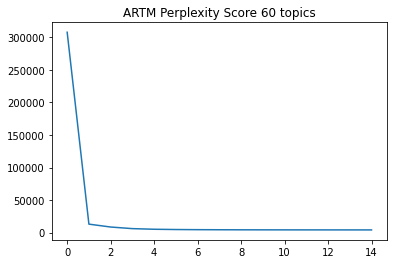

In [585]:
plt.plot(model.score_tracker['PerplexityScore'].value)
plt.title('ARTM Perplexity Score ' + str(T) + ' topics')

Show top words for each topic. If some words are in many topics, decrease SparsityPhi Regulalizer coefficient `tau`.

In [586]:
tops = [str(k)+':'+' '.join(v) for k, v in model.score_tracker['top_words'].tokens[-1].items()]

In [587]:
#tops

['topic_0:город_NOUN год_NOUN территория_NOUN тысяча_NOUN часть_NOUN столица_NOUN армянский_ADJF век_NOUN история_NOUN армения_NOUN время_NOUN грузия_NOUN центр_NOUN северный_ADJF южный_ADJF',
 'topic_1:церковь_NOUN год_NOUN храм_NOUN монастырь_NOUN святой_ADJF православный_ADJF собор_NOUN епископ_NOUN духовный_ADJF епархия_NOUN митрополит_NOUN церковный_ADJF священник_NOUN русский_ADJF архиепископ_NOUN',
 'topic_2:епископ_NOUN год_NOUN епархия_NOUN итальянский_ADJF папа_NOUN римский_ADJF католический_ADJF италия_NOUN святой_ADJF архиепископ_NOUN апостольский_ADJF церковь_NOUN рим_NOUN ссылка_NOUN мария_NOUN',
 'topic_3:год_NOUN уезд_NOUN губерния_NOUN состав_NOUN 1918_NUMR 1920_NUMR 1917_NUMR 1919_NUMR число_NOUN 1924_NUMR городской_ADJF волость_NOUN провинция_NOUN войти_VERB 1927_NUMR',
 'topic_4:остров_NOUN метр_NOUN озеро_NOUN гора_NOUN часть_NOUN вода_NOUN северный_ADJF территория_NOUN море_NOUN высота_NOUN горный_ADJF морской_ADJF южный_ADJF парк_NOUN долина_NOUN',
 'topic_5:дере

In [62]:
# Save topics in a text file, if needed.
# with open('example_topics.txt', 'wt', encoding='utf-8') as f:
#     [print(i, file=f) for i in a]

In [92]:
# phi = model.get_phi()
# theta = model.get_theta()     # if needed, set cache_theta=True before running

`TODO Next (Next Jupyter Notebook):`
1. Function to create several topic models with `[30,40,50,60,70,80,90,100]` topics. Save `Perplexity` & `Sparsity` (Phi, Theta) scores. Add option to add regularizers with custom `tau` value.  `Done`
2. Load & Preprocess (`clean+pos+lemma`) Metaphor Corpus. `Done`
3. Save `Theta` matrices for Metaphor Corpus, transformed with Topic models. `Done`
3. Function to run classifications on `Theta` matrices and save scores (`acc, prec, recall, f1`) for each model.
* Check models on each subcorpus, if there's time left (not likely).  `Done`
4. Simple Neural Network Classifier (Pytorch or Keras). `Done`
5. Beautiful visualizations of the results with matplotlib and seaborn. Confusion Matrices for models. `Done`


### Batching Metaphor Corpus and Fitting it in the Topic Model

In [28]:
# When creating batch_vectorizer for the corpus for the first time
# met_batch_vectorizer = artm.BatchVectorizer(data_path='metcorp_vw.txt', data_format='vowpal_wabbit',
#                                             target_folder='metcorp_batches')

In [9]:
# When you already have batches (runs much faster):
met_batch_vectorizer = artm.BatchVectorizer(data_path='metcorp_batches', data_format='batches')

Use `transform` to obtain `Theta` matrix from the trained topic model for the new texts. Make sure to check the values - if the model is too sparse, `Theta` matrix for the new docs will consist of zeros.

If the model is sparse, most of the values will be zero, and some will be decimals that add up to 1 for each document. Not less, not more, exactly 1.0. 

If the model is smooth (dense), all the values will be filled with decimals. All values should still add up to 1 for each document. Not less, not more, exactly 1.0. 

Neither can be considered better, you should experoment, find optimal distribution and preferrably test topic features extrinsically, for example on a classification task.

In [588]:
theta_test = model.transform(met_batch_vectorizer)
theta_test

,5000,5001,5002,5003,5004,5005,5006,5007,5008,5009,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
topic_0,0.000000,0.000000,0.345320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_1,0.069148,0.000000,0.000000,0.000000,0.000000,0.000000,0.002174,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034967,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_3,0.067156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_4,0.000000,0.000000,0.000000,0.000000,0.000181,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027785,0.000000,0.013078
topic_5,0.008938,0.000000,0.000000,0.000000,0.000080,0.058213,0.000000,0.000000,0.565957,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.162819,0.037157,0.000000,0.000000,0.008072
topic_6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_7,0.002222,0.011927,0.000000,0.000000,0.132038,0.000000,0.064131,0.000000,0.000000,0.000000,...,0.231649,0.000000,0.000000,0.000000,0.000000,0.010410,0.000000,0.074630,0.000000,0.001807
topic_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033803,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
topic_9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.112558,0.000000,0.000000,0.000000,...,0.075607,0.000000,0.000000,0.000000,0.073346,0.000000,0.000000,0.000000,0.000000,0.000000


Check that all values add up to 1.0. If the model is too sparse, the values will be 0.0.

In [544]:
import numpy as np
np.sum(theta_test)

5000    1.0
5001    1.0
5002    1.0
5003    1.0
5004    1.0
       ... 
3995    1.0
3996    1.0
3997    1.0
3998    1.0
3999    1.0
Length: 7077, dtype: float32

Save theta as csv to further pass it to the classifier as features.

Here, we also add lemmas and target class info in the dataframe.

In [576]:
df = pd.DataFrame()
df['sents'] = processed_sents
df['targets'] = processed_targets
df = df.join(theta_test.T)
df.head(3)

,sents,targets,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,...,topic_50,topic_51,topic_52,topic_53,topic_54,topic_55,topic_56,topic_57,topic_58,topic_59
0,нужно_PRED весь_ADJF время_NOUN бомбардировать...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,добрынин_NOUN говорить_VERB шевченко_NOUN цент...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093341,0.060538,0.000000,0.000000,0.402347,0.0,0.0,0.002572,0.0,0.0
2,принять_INFN внимание_NOUN настойчиво_ADVB гру...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.096032,0.142632,0.011187,0.0,0.0,0.000000,0.0,0.0


In [577]:
df.to_csv('metcorp_tm.csv')

## Bulk Building  & Scoring Topic Models + Transforming Metcorp & Saving Theta tables for Future Classification


In [10]:
import json

In [11]:
def build_tms(topic_nums, batch_vectorizer, dictionary, num_collection_passes,
              regularizers, met_batch_vectorizer, source_df, add_to_name='', save_models=False):
    '''
    Trains and scores multiple topic models with given target topic nums.
    Args:
      topic nums:            list of integers, e.g. [20,30,40], with number of topics for each model
      batch_vectorizer:      BigARTM BatchVectorizer class object for wiki texts
      dictionary:            BigARTM Dictionary class object
      num_collection_passes: parameter for .fit_offline() method. Number of passes through the corpus
      regularizers:          regularizers with custom `tau` parameter to add to the model
      met_batch_vectorizer:  BigARTM BatchVectorizer class object for metaphor corpus
      source_df:             Dataframe with original sentences and labels
      add_to_name:           str, will be added to saved theta dataframe filenames and report names
                             as an additional identifier. Leave as is, if unnecessary.
      save_models:           if True, each model will be saved to disk as
                             `'artm_p_wt_'+add_to_name+str(num_t)` and `'artm_n_wt_'+add_to_name+str(num_t)`.
                             To save memory, leave `save_models=False`
    '''
    clear_stdin()   # defined above, fixes tqdm library newline glitches
    
    tm_results = {}
    top_words = []

    for topic_n in tqdm(topic_nums):
        tm_scores = {'PerplexityScore': None, 'SparsityPhiScore': None, 'SparsityThetaScore': None}
        
        model = artm.ARTM(num_topics=topic_n, dictionary=dictionary, 
                          cache_theta=False)
        # Scores
        model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
        model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
        model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
        model.scores.add(artm.TopTokensScore(name='top_words', num_tokens=15))
        
        # Add regularizers
        for reg in regularizers:
            model.regularizers.add(reg)
        
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=num_collection_passes)
        
        if save_models:
            model.save(f'./artm/artm_p_wt_{add_to_name}'+str(topic_n), model_name='p_wt')
            model.save(f'./artm/artm_n_wt_{add_to_name}'+str(topic_n), model_name='n_wt')
            
        tm_scores['PerplexityScore'] = np.round(model.get_score('PerplexityScore').value)
        tm_scores['SparsityPhiScore'] = np.round(model.get_score('SparsityPhiScore').value, 2)
        tm_scores['SparsityThetaScore'] = np.round(model.get_score('SparsityThetaScore').value, 2)
        
        # Save Perplexity plot
        fig = plt.figure()
        plt.plot(model.score_tracker['PerplexityScore'].value)
        plt.title('ARTM Perplexity Convergence Score ' + str(topic_n) + ' topics')
        plt.savefig(f'./artm/img/perplexity_{add_to_name}{str(topic_n)}.png')
        plt.close(fig)
    
        top_words.append([str(k)+': '+' '.join(v) for k, v in model.score_tracker['top_words'].tokens[-1].items()])
        tm_results[topic_n] = tm_scores
        
        metcorp_theta = model.transform(met_batch_vectorizer)
        source_df.join(metcorp_theta.T).to_csv(f'./artm/thetas/metcorp_tm_{add_to_name}{topic_n}.csv')
    
    with open(f'./artm/top_words_for_topics_{add_to_name}.txt', 'wt', encoding='utf-8') as f:
        for n, words in zip(topic_nums, top_words):
            print(f'Top Words for {n} Topics', file=f)
            [print(i, file=f) for i in words]
            print(file=f)
    
    with open(f'./artm/scores_{add_to_name}.txt', 'wt', encoding='utf-8') as f:
        json.dump(tm_results, f, indent=2)
    
    return tm_results, top_words

In [12]:
#Preparation
artm_regs_sparse = [artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer', tau=-1.0),
                    artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer', tau=-0.5),
                    artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', tau=1e+2)
                   ]

#Preparation
artm_regs_dense = [artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer', tau=-1.0),
                    artm.SmoothSparseThetaRegularizer(name='sparse_theta_regularizer', tau=0.5),
                    artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', tau=1e+2)
                   ]

df = pd.read_csv('metcorp.csv', index_col=False)

# [40,50,60,70,80,90,100]

In [15]:
dense_results, dense_top_words = build_tms(topic_nums=[30,40,50,60,70,80,90,100,110,120,130], 
                        batch_vectorizer=batch_vectorizer, 
                        dictionary=dictionary, num_collection_passes=10, regularizers=artm_regs_dense, 
                        met_batch_vectorizer=met_batch_vectorizer, source_df=df, add_to_name='dense_2',
                        save_models=False)

100%|██████████| 11/11 [2:00:56<00:00, 659.69s/it]


In [79]:
sparse_results, sparse_top_words = build_tms(topic_nums=[30,40,50,60,70,80,90,100,110,120,130], 
                        batch_vectorizer=batch_vectorizer, 
                        dictionary=dictionary, num_collection_passes=10, regularizers=artm_regs_sparse, 
                        met_batch_vectorizer=met_batch_vectorizer, source_df=df, add_to_name='sparse_2',
                        save_models=False)

100%|██████████| 11/11 [2:11:08<00:00, 715.36s/it]


In [75]:
sparse_results

{40: {'PerplexityScore': 4669.0,
  'SparsityPhiScore': 0.93,
  'SparsityThetaScore': 0.73},
 50: {'PerplexityScore': 4322.0,
  'SparsityPhiScore': 0.94,
  'SparsityThetaScore': 0.76},
 60: {'PerplexityScore': 4065.0,
  'SparsityPhiScore': 0.95,
  'SparsityThetaScore': 0.78},
 70: {'PerplexityScore': 3898.0,
  'SparsityPhiScore': 0.96,
  'SparsityThetaScore': 0.8},
 80: {'PerplexityScore': 3803.0,
  'SparsityPhiScore': 0.96,
  'SparsityThetaScore': 0.81},
 90: {'PerplexityScore': 3686.0,
  'SparsityPhiScore': 0.97,
  'SparsityThetaScore': 0.83}}

In [39]:
def plot_scores(artm_scores, show=True, save_dir='./artm/img/'):
    '''
    Plot build_tms scores. Plots separate plots for perplexity and sparsity.
    
    Args:
        artm_scores:     dictionary of dictionaries with scores for all trained topic models.
        show:            whether to display the plot as output or only save it
    '''
                
    n_topics = []
    perplexity = []
    phi = []
    theta = []
    pt_labels = []

    for n_t, scores in artm_scores.items():
        n_topics.append(n_t)
        perplexity.append(scores['PerplexityScore'])
        phi.append(scores['SparsityPhiScore'])
        theta.append(scores['SparsityThetaScore'])
        if len(pt_labels) == 0:
            pt_labels.extend(list(scores.keys()))

    def plot_scores(scores, topics, legend, add_to_title_name='', add_to_filename=''):

        fig = plt.figure(figsize=(7,3))

        for i in scores:
            plt.plot(i)
            
        title = f"{add_to_title_name} for  {'-'.join([str(i) for i in n_topics])} topics"
        plt.title(title)
        plt.xlabel('Number of Topics')
        plt.ylabel('Scores')
        
        plt.xticks(list(range(len(topics))), topics)
        
        plt.legend(legend, loc='best')
        plt.grid()

        plt.savefig(f"{save_dir}{add_to_filename}_{'-'.join([str(i) for i in n_topics])}.png")

        nonlocal show    # define show as nonlocal so it binds to the outer function parameter

        if show:                # global variable
            plt.show(fig)
        else:
            plt.close(fig)
                    
    plot_scores(scores=[perplexity], topics=n_topics, legend=pt_labels,
                add_to_title_name='Perrplexity Scores', add_to_filename='perplexity_scores')
    plot_scores(scores=[phi, theta], topics=n_topics, legend=pt_labels[1:],
                add_to_title_name='Phi&Theta Scores', add_to_filename='phi-theta_scores')

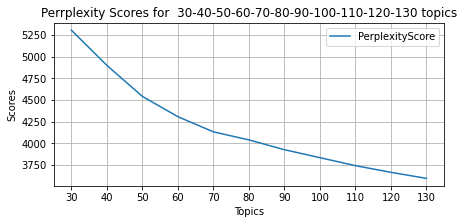

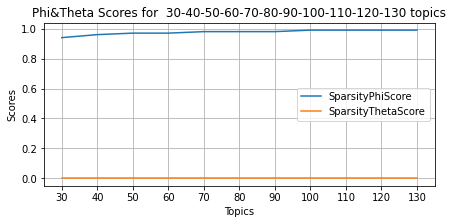

In [40]:
plot_scores(dense_results)

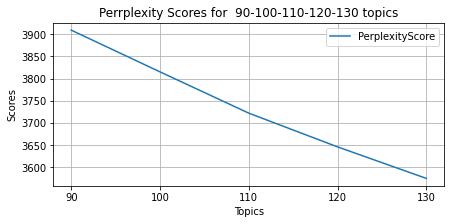

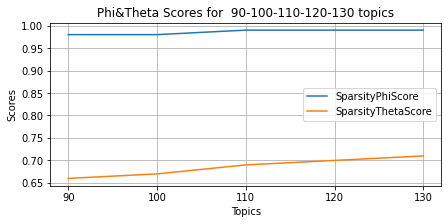

In [41]:
plot_scores(sparse_results)

## Bulk LDA Training

In [60]:
def build_ldas(topic_nums, batch_vectorizer, dictionary, num_collection_passes,
              met_batch_vectorizer, source_df, add_to_name='', save_models=False):
    '''
    Trains and scores multiple topic models with given target topic nums.
    Args:
      topic nums:            list of integers, e.g. [20,30,40], with number of topics for each model
      batch_vectorizer:      BigARTM BatchVectorizer class object for wiki texts
      dictionary:            BigARTM Dictionary class object
      num_collection_passes: parameter for .fit_offline() method. Number of passes through the corpus
      met_batch_vectorizer:  BigARTM BatchVectorizer class object for metaphor corpus
      source_df:             Dataframe with original sentences and labels
      add_to_name:           str, will be added to saved theta dataframe filenames and report names
                             as an additional identifier. Leave as is, if unnecessary.
      save_models:           if True, each model will be saved to disk as
                             `'artm_p_wt_'+add_to_name+str(num_t)` and `'artm_n_wt_'+add_to_name+str(num_t)`.
                             To save memory, leave `save_models=False`
    '''
    clear_stdin()   # defined above, fixes tqdm library newline glitches
    
    tm_results = {}
    top_words = []

    for topic_n in tqdm(topic_nums):
        tm_scores = {'PerplexityScore': None, 'SparsityPhiScore': None, 'SparsityThetaScore': None}
        
        lda = artm.LDA(num_topics=topic_n, alpha=0.01, beta=0.001, cache_theta=False,
               num_document_passes=10, dictionary=dictionary)
        
        lda.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
        
        if save_models:
            lda.save(f'./artm/lda_p_wt_{add_to_name}'+str(topic_n), model_name='p_wt')
            lda.save(f'./artm/lda_n_wt_{add_to_name}'+str(topic_n), model_name='n_wt')
            
        tm_scores['PerplexityScore'] = np.round(lda.perplexity_last_value)
        tm_scores['SparsityPhiScore'] = np.round(lda.sparsity_phi_last_value, 2)
        tm_scores['SparsityThetaScore'] = np.round(lda.sparsity_theta_last_value, 2)
        
        # Save Perplexity plot
        fig = plt.figure()
        plt.plot(lda.perplexity_value)
        plt.title('LDA Perplexity Convergence Score ' + str(topic_n) + ' topics')
        plt.savefig(f'./artm/img/perplexity_{add_to_name}{str(topic_n)}.png')
        plt.close(fig)
        
        top_tokens = lda.get_top_tokens(num_tokens=10)      
        top_words.append(['Topic #{0}: {1}'.format(i, token_list) for i, token_list in enumerate(top_tokens)])
        
        tm_results[topic_n] = tm_scores
        
        metcorp_theta = lda.transform(met_batch_vectorizer)
        source_df.join(metcorp_theta.T).to_csv(f'./artm/thetas/metcorp_tm_{add_to_name}{topic_n}.csv')
    
    with open(f'./artm/top_words_for_topics_{add_to_name}.txt', 'wt', encoding='utf-8') as f:
        for n, words in zip(topic_nums, top_words):
            print(f'Top Words for {n} Topics', file=f)
            [print(' '.join(i), file=f) for i in words]
            print(file=f)
    
    with open(f'./artm/scores_{add_to_name}.txt', 'wt', encoding='utf-8') as f:
        json.dump(tm_results, f, indent=2)
    
    return tm_results, top_words

In [61]:
lda_results, lda_top_words = build_ldas(topic_nums=[30,40,50,60,70,80,90,100,110,120,130], 
                             batch_vectorizer=batch_vectorizer, 
                             dictionary=dictionary, num_collection_passes=10,
                             met_batch_vectorizer=met_batch_vectorizer, source_df=df, add_to_name='lda',
                             save_models=False)

100%|██████████| 11/11 [2:16:05<00:00, 742.28s/it]


In [62]:
lda_results

{30: {'PerplexityScore': 4749.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 40: {'PerplexityScore': 4328.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 50: {'PerplexityScore': 3972.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 60: {'PerplexityScore': 3675.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 70: {'PerplexityScore': 3506.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 80: {'PerplexityScore': 3402.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 90: {'PerplexityScore': 3302.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 100: {'PerplexityScore': 3194.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 110: {'PerplexityScore': 3113.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 120: {'PerplexityScore': 3036.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0},
 130: {'PerplexityScore': 2948.0,
  'SparsityPhiScore': 0.0,
  'SparsityThetaScore': 0.0}}